In [1]:
import pandas as pd

In [10]:
import seaborn as sns

In [11]:
import matplotlib.pyplot as plt

In [12]:
import sklearn

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

In [14]:
from sklearn.metrics import root_mean_squared_error

In [15]:
from sklearn.feature_extraction import DictVectorizer

In [8]:
pd.__version__
sklearn.__version__

'1.4.0'

In [9]:
!pip install pyarrow

In [3]:
def read_dataframe(filename):    
    df = pd.read_parquet(filename)

    df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)
    df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime

    td = df.duration.iloc[0]
    df['duration'] = df.duration.apply(lambda td: td.total_seconds()/60)

    categorical = ['PULocationID','DOLocationID']

    df[categorical] = df[categorical].astype(str)

    return df


In [4]:
df = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet')
df_val = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet')

In [5]:
# Since duration is added, subtracting 1
num_columns = len(df.columns)-1
print(num_columns)

19


In [6]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00,8.433333
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00,6.316667
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00,12.750000
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25,9.616667
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00,10.833333


In [7]:
std_dev = df['duration'].std(ddof=0)

In [8]:
std_dev

42.5943442974141

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='duration', ylabel='Density'>

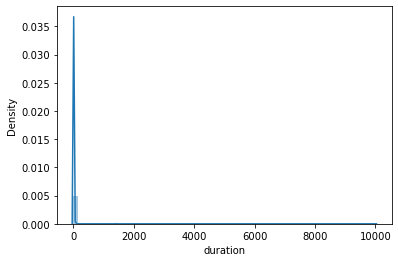

In [16]:
sns.distplot(df.duration)

In [17]:
df.duration.describe(percentiles = [0.95,0.98,0.99])

count    3.066766e+06
mean     1.566900e+01
std      4.259435e+01
min     -2.920000e+01
50%      1.151667e+01
95%      3.646667e+01
98%      4.873333e+01
99%      5.725000e+01
max      1.002918e+04
Name: duration, dtype: float64

In [18]:
((df.duration >=1) & (df.duration<=60)).mean()

0.9812202822125979

In [19]:
df = df[(df.duration >=1) & (df.duration<=60)]

In [20]:
df_val = df_val[(df_val.duration >=1) & (df_val.duration<=60)]

In [21]:
dv = DictVectorizer()

# to implement one hot encoding we need to use dictionary vectorizer. 
# And dictionary vectorizer treates everything thats not a number as a categorical variable

categorical = ['PULocationID','DOLocationID']
numerical = ['trip_distance']

# But here categorical variables is a number, so convert them to string
df[categorical] = df[categorical].astype(str)
df_val[categorical] = df_val[categorical].astype(str)

train_dict = df[categorical + numerical].to_dict(orient = 'records')

# there are 2 steps here in order to train the dataset
# 1. fit the values (in other words - it learns about the parameters from the input (categorical, numerical) and
# and calculates mean/variance for scaling, or builds vocabulary in a vectorizer.
# 2. transform - applies the learned parameters to the dataset.
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numerical].to_dict(orient = 'records')
X_val = dv.transform(val_dict)

In [22]:
X_train

<3009173x516 sparse matrix of type '<class 'numpy.float64'>'
	with 9027519 stored elements in Compressed Sparse Row format>

In [23]:
# estimate the score of this model and use rmse for error computation
target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

rmse_jan = root_mean_squared_error(y_train, y_pred)

In [24]:
rmse_jan

7.649143388169879

In [24]:
y_val = df_val[target].values
y_pred_val = lr.predict(X_val)
rmse_feb = root_mean_squared_error(y_val, y_pred_val)

In [25]:
rmse_feb

7.811472580390592

In [27]:
X_train.shape[1]

516

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


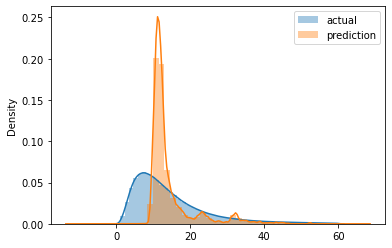

In [26]:
sns.distplot(y_train, label = "actual")
sns.distplot(y_pred, label = "prediction")

plt.legend()

In [29]:
import pickle

In [30]:
with open('models/lin_reg_yellow_taxi.bin','wb') as f_out:
    pickle.dump((dv,lr),f_out)